In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import gc

from sklearn import metrics as skm
from sklearn.model_selection import train_test_split
from scipy.optimize import differential_evolution
from keras import backend
from keras import layers
from keras import models
from keras import callbacks as kc
from keras import optimizers as ko
from keras import initializers, regularizers, constraints, activations
from keras.engine import Layer
import keras.backend as K
from keras.layers import merge
import matplotlib.pyplot as plt

print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


['coref-by-mlp-on-glove', 'gendered-pronoun-resolution', 'coref-by-mapped-mlp-model-on-layerwise-lbert', 'coref-by-flat-pair-mlp-model-on-layerwise-lbert3', 'coref-by-mapped-mlp-model-on-layerwise-lbert3', 'coref-by-flat-pair-mlp-model-on-layerwise-bert', 'coref-by-mapped-mlp-model-on-layerwise-lbert2', 'coref-by-flat-pair-mlp-model-on-layerwise-lbert', 'coref-by-mapped-mlp-model-on-layerwise-bert', 'coref-by-flat-pair-mlp-model-on-layerwise-lbert2', 'coref-by-rnn-attention-on-glove']


In [2]:
DATA_ROOT = '../input/'
SUB_DATA_FOLDER = os.path.join(DATA_ROOT, 'gendered-pronoun-resolution')
MLPGLOVE_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-mlp-on-glove')
RNNGLOVE_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-rnn-attention-on-glove')

PAIRBERT_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-flat-pair-mlp-model-on-layerwise-bert')
TripletBERT_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-mapped-mlp-model-on-layerwise-bert')

PAIRLBERT_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-flat-pair-mlp-model-on-layerwise-lbert')
TripletLBERT_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-mapped-mlp-model-on-layerwise-lbert')
PAIRLBERT2_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-flat-pair-mlp-model-on-layerwise-lbert2')
TripletLBERT2_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-mapped-mlp-model-on-layerwise-lbert2')
PAIRLBERT3_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-flat-pair-mlp-model-on-layerwise-lbert3')
TripletLBERT3_DATA_FOLDER = os.path.join(DATA_ROOT, 'coref-by-mapped-mlp-model-on-layerwise-lbert3')

# Import Data

## Train Data

In [3]:
base_name_list = list()

# mention-pair glove
base_name = os.path.join(MLPGLOVE_DATA_FOLDER, "flatmlp_glove")
base_name_list.append(base_name)

# mention-triplet glove
base_name = os.path.join(MLPGLOVE_DATA_FOLDER, "mapmlp_glove")
base_name_list.append(base_name)

# rnn glove
base_name = os.path.join(RNNGLOVE_DATA_FOLDER, "rnnattetion_glove")
base_name_list.append(base_name)

# mention-pair bert
base_name = os.path.join(PAIRBERT_DATA_FOLDER, "flatpairmlp_layer")
for i in range(12):
    base_name_list.append(base_name + str(i))
    
# mention-triplet bert
base_name = os.path.join(TripletBERT_DATA_FOLDER, "mappedmlp_layer")
for i in range(12):
    base_name_list.append(base_name + str(i))
    
# mention-pair large bert
base_name = os.path.join(PAIRLBERT_DATA_FOLDER, "flatpairmlp_layer")
for i in range(6):
    base_name_list.append(base_name + str(i))

# mention-triplet large bert
base_name = os.path.join(TripletLBERT_DATA_FOLDER, "mappedmlp_layer")
for i in range(6):
    base_name_list.append(base_name + str(i))
    
# mention-pair large bert2
base_name = os.path.join(PAIRLBERT2_DATA_FOLDER, "flatpairmlp_layer")
for i in range(6):
    base_name_list.append(base_name + str(i))
    
# mention-triplet large bert2
base_name = os.path.join(TripletLBERT2_DATA_FOLDER, "mappedmlp_layer")
for i in range(6):
    base_name_list.append(base_name + str(i))
    
# mention-pair large bert3
base_name = os.path.join(PAIRLBERT3_DATA_FOLDER, "flatpairmlp_layer")
for i in range(6):
    base_name_list.append(base_name + str(i))

# mention-triplet large bert3
base_name = os.path.join(TripletLBERT3_DATA_FOLDER, "mappedmlp_layer")
for i in range(6):
    base_name_list.append(base_name + str(i))


In [4]:
train_file_names = list()
dev_file_names = list()
test_file_names = list()

train_file_names = [file_name + "_train.csv" for file_name in base_name_list]
dev_file_names = [file_name + "_dev.csv" for file_name in base_name_list]
test_file_names = [file_name + "_test.csv" for file_name in base_name_list]

In [5]:
train_dfs = [
    pd.read_csv(file_path).dropna() for file_path in train_file_names
]

dev_dfs = [
    pd.read_csv(file_path) for file_path in dev_file_names
]

test_dfs = [
    pd.read_csv(file_path) for file_path in test_file_names
]

In [6]:
print(train_dfs[0].shape)
print(train_dfs[1].shape)

(4000, 13)
(4000, 13)


# Encode Data

In [7]:
def _ground_row_to_y(row):
    if row.loc['A-coref']:
        return 0
    if row.loc['B-coref']:
        return 1
    return 2

def df_to_x(df):
    return df[['A', 'B', 'NEITHER']].values

In [8]:
# ground
y_train = train_dfs[0].apply(_ground_row_to_y, axis=1)
y_dev = dev_dfs[0].apply(_ground_row_to_y, axis=1)

# x
X_train = np.stack([df_to_x(df_) for df_ in train_dfs], axis=1)
X_dev = np.stack([df_to_x(df_) for df_ in dev_dfs], axis=1)
X_test = np.stack([df_to_x(df_) for df_ in test_dfs], axis=1)

# Log Loss

In [9]:
def measure_log_loss(ground, preds):
    preds = preds.tolist()
    return skm.log_loss(ground, preds, labels=[0, 1, 2], eps=10**-15)

In [10]:
print(measure_log_loss(y_train, X_train[:,-5,:]))

0.5769689700224185


# Ensemble Models

## Ensemble Baseline

In [11]:
y_preds = np.mean(X_dev, axis=1)

In [12]:
print(measure_log_loss(y_dev, y_preds))

0.4305603135202857


## Weighted Average By Stochastic Global Search 

In [13]:
# normalize a vector to have unit norm
def normalize(weights):
    # calculate l1 vector norm
    #print(weights.shape)
    result = np.linalg.norm(weights, 1)
    # check for a vector of all zeros
    if result == 0.0:
        return weights
    # return normalized vector (unit norm)
    return weights / result

def wa_model(weights, X_meta_list):
    # normalize weights
    normalized = normalize(weights)
    
    X_meta = np.array(X_meta_list)
    # weighted sum across ensemble members
    summed = np.tensordot(X_meta, normalized, axes=((0),(0)))
    return summed
    
def loss_function(weights, X_meta_list, y):
    y_pred_ = wa_model(weights, X_meta_list)
    
    return measure_log_loss(y, y_pred_)

In [14]:
def ensemble(X_meta_list, y, X_test_meta_list):
    # define bounds on each weight
    bound_w = [(0.0, 1.0)  for _ in range(len(X_meta_list))]
    # arguments to the loss function
    search_arg = (X_meta_list, y)
    # global optimization of ensemble weights
    weights = differential_evolution(loss_function, bound_w, search_arg, maxiter=1000, tol=1e-7)['x']
    
    print(normalize(weights))
    
    return wa_model(weights, X_test_meta_list)

In [15]:
# y_preds = ensemble(x_trains, y_train, x_trains)

In [16]:
# print(measure_log_loss(y_test, y_preds))

## Weighted Average By Keras

In [17]:
class WeightedAverage(Layer):

    def __init__(self,**kwargs):

        self.supports_masking = False
        self.init = initializers.get('lecun_normal')
        
        self.w_regularizer = regularizers.get(None)
        self.w_constraint = constraints.get(None)
        
        super(WeightedAverage, self).__init__(**kwargs)

    def build(self, input_shape):

        self.w = self.add_weight((input_shape[1], ),
                                 initializer=self.init,
                                 name='{}_ww'.format(self.name),
                                 regularizer=self.w_regularizer,
                                 constraint=self.w_constraint)

    def compute_mask(self, input, input_mask=None):
        # do not pass the mask to the next layers
        return None

    def call(self, inputs, mask=None):
        x = inputs
        
        w = activations.sigmoid(self.w)
        w = w / (K.sum(w) + K.epsilon())
        w = K.expand_dims(w)
        print(w.shape)
        weighted_input = x * w
        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], input_shape[-1]

    def get_config(self):
        config = {
        }
        base_config = super(WeightedAverage, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [18]:
def build_ensemble_model(num_models, input_dims, output_dims):
    
    # inputs
    inputs = models.Input(shape=(num_models, input_dims), dtype='float32', name='input')
    
    x = inputs
    
    outputs = WeightedAverage(name="softmax_layer")(x)
    
    model = models.Model(inputs, outputs)
    return model

In [19]:
def ensemble(X_, y, X_test_):
    en_model = build_ensemble_model(X_.shape[1], 3, 3)
    adam = ko.Adam()
    early_stop = kc.EarlyStopping(monitor = "loss", mode = "min", patience=5)
    en_model.compile(adam, loss="sparse_categorical_crossentropy")
    
    print(en_model.summary())
    
    history = en_model.fit(X_, y, batch_size=32, epochs=5000, callbacks = [early_stop], verbose=0)
    
    print("train loss: ")
    print(history.history['loss'][-1])
    plt.plot(history.history['loss'])
    plt.title('train loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.show()
    
    return en_model.predict(X_test_), en_model

Instructions for updating:
Colocations handled automatically by placer.
(63, 1)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 63, 3)             0         
_________________________________________________________________
softmax_layer (WeightedAvera (None, 3)                 63        
Total params: 63
Trainable params: 63
Non-trainable params: 0
_________________________________________________________________
None
Instructions for updating:
Use tf.cast instead.
train loss: 
0.33232274985313415


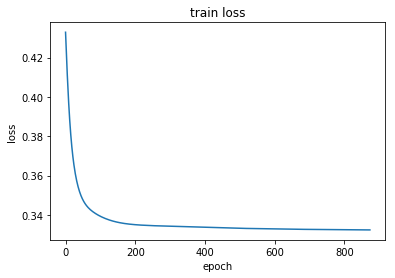

In [20]:
y_preds, model1 = ensemble(X_train, y_train, X_dev)

In [21]:
print(measure_log_loss(y_dev, y_preds))

0.31434844520399874


## Linear Regression By Keras

In [22]:
def build_ensemble_model(num_models, input_dims, output_dims):
    
    # inputs
    inputs = models.Input(shape=(num_models, input_dims), dtype='float32', name='input')
    x = inputs
    
    x = layers.Flatten(name='flatten_layer')(x)
    outputs = layers.Dense(3, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 63, 3)             0         
_________________________________________________________________
flatten_layer (Flatten)      (None, 189)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 570       
Total params: 570
Trainable params: 570
Non-trainable params: 0
_________________________________________________________________
None
train loss: 
0.31779979664087293


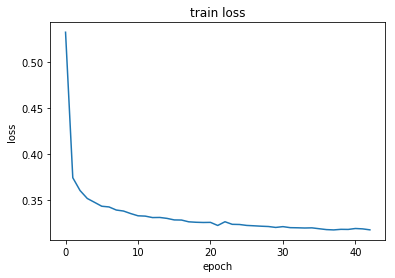

In [23]:
y_preds, model2 = ensemble(X_train, y_train, X_dev)

In [24]:
print(measure_log_loss(y_dev, y_preds))

0.31651661631181927


# Save Results

In [25]:
pred1 = model1.predict(X_test)
sub_df_path = os.path.join(SUB_DATA_FOLDER, 'sample_submission_stage_1.csv')
sub_df = pd.read_csv(sub_df_path)
sub_df.loc[:, 'A'] = pd.Series(pred1[:, 0])
sub_df.loc[:, 'B'] = pd.Series(pred1[:, 1])
sub_df.loc[:, 'NEITHER'] = pd.Series(pred1[:, 2])
sub_df.to_csv("submission1.csv", index=False)

In [26]:
pred2 = model2.predict(X_test)
sub_df_path = os.path.join(SUB_DATA_FOLDER, 'sample_submission_stage_1.csv')
sub_df = pd.read_csv(sub_df_path)
sub_df.loc[:, 'A'] = pd.Series(pred2[:, 0])
sub_df.loc[:, 'B'] = pd.Series(pred2[:, 1])
sub_df.loc[:, 'NEITHER'] = pd.Series(pred2[:, 2])
sub_df.to_csv("submission2.csv", index=False)